In [150]:
import sys
import os
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [151]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score, SCORERS, f1_score, make_scorer, roc_auc_score, plot_confusion_matrix, precision_recall_fscore_support
from model_training import WordCountTransformer, CharacterCountTransformer, StopWordFrequency

In [152]:
answerable_data = utils.load_data('../data/aqfiltered.json', 'answerable')

In [153]:
stop_words = set(stopwords.words('English'))

In [154]:
def answerable_preprocessor(sentence):
    sentence = utils.check_quotations(sentence)
    sentence = word_tokenize(sentence)
    
    for i in range(len(sentence)):
        sentence[i] = utils.check_backslash(sentence[i])
        sentence[i] = utils.check_camel_snakecase(sentence[i])
        sentence[i] = sentence[i].lower()
        
        if sentence[i] in stop_words and sentence[i] not in ['who', 'what', 'when', 'where', 'why', 'how']:
            sentence[i] = ""
        if sentence[i].isnumeric():
            sentence[i] = "numericnumber"
        elif utils.is_spelled_out_number(sentence[i]):
            sentence[i] = "nonnumericnumber"
        elif utils.is_TA_or_instructor_name(sentence[i]):
            sentence[i] = "name"
        elif utils.is_error_code(sentence[i]):
            sentence[i] = "errorcode"
        elif utils.is_filename(sentence[i]):
            sentence[i] = "filename"
        elif utils.is_system_word(sentence[i]):
            sentence[i] = "sys"
        elif utils.is_function(sentence[i]):
            sentence[i] = "func"

    return ' '.join(sentence)

In [155]:
for i in range(len(answerable_data)):
    print(answerable_data[:,0][i])
    print(answerable_preprocessor(answerable_data[:,0][i]))
    print()

Trying to figure out my get completion funciton
trying  figure   get completion funciton

We're not quite sure how to allocate and free memory correctly for the shapes going of screen. We tried to store them in an array based off how many shapes could fit on the screen at a time, free the one that goes off the screen, and push all the others up, but we're getting a memory use after free error. How do we free the thing itself without giving up its spot in an array?
  quite sure how  allocate  free memory correctly   shapes going  screen .  tried  store    array based  how many shapes could fit   screen   time , free  nonnumericnumber  goes   screen ,  push   others  ,   getting  memory use  free error . how   free  thing  without giving   spot   array ?

Meltdown is just running in an infinite loop
meltdown   running   infinite loop

not sure how to implement keyset
 sure how  implement keyset

what do IDeque, IQueue, and IStack mean
what  camelsnakecase , camelsnakecase ,  camelsnakeca

In [156]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('vectorizer', TfidfVectorizer(preprocessor=None)),
#         ('char_count', CharacterCountTransformer()),
#         ('word_count', WordCountTransformer())
    ])),
    ('clf', LogisticRegression(max_iter=1000))
#     ('clf', RandomForestClassifier())
#     ('clf', MultinomialNB())
])

pipeline.fit(answerable_data[:,0], answerable_data[:,1])
np.mean(cross_val_score(pipeline, answerable_data[:,0], answerable_data[:,1]))

0.7152156862745099

In [162]:
y_pred = cross_val_predict(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5)
conf_mat = confusion_matrix(answerable_data[:,1], y_pred, labels=['t', 'f', 'c'])


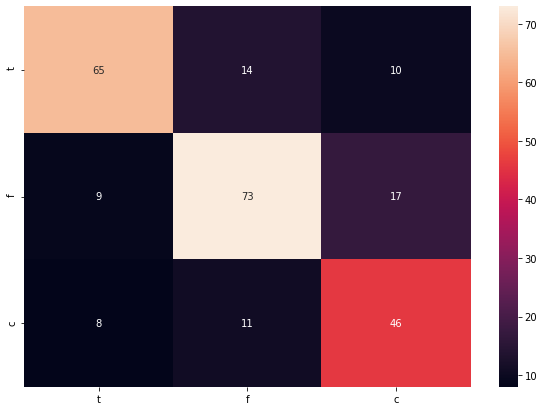

In [158]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['t', 'f', 'c']],
                  columns = [i for i in ['t', 'f', 'c']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [159]:
print(classification_report(answerable_data[:,1], y_pred))

              precision    recall  f1-score   support

           c       0.63      0.71      0.67        65
           f       0.74      0.74      0.74        99
           t       0.79      0.73      0.76        89

    accuracy                           0.73       253
   macro avg       0.72      0.73      0.72       253
weighted avg       0.73      0.73      0.73       253



In [165]:
param_grid = {
    'features__vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'features__vectorizer__max_features': [None, 100, 250, 500, 1000, 1500, 2000, 2500, 3000],
    'clf__C': [.01, .1, 1, 10, 100],
    'clf__class_weight': [None, 'balanced']
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
# search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, n_iter=100)
search.fit(answerable_data[:,0], answerable_data[:,1])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('vectorizer',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                                

In [164]:
np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5))

0.7510588235294119

In [21]:
t_precision = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(precision_score, average='macro'), n_jobs=-1))
t_recall = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(recall_score, average='macro'), n_jobs=-1))
t_f1 = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1))
                
# f_precision = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(precision_score, pos_label='f', average='micro'), n_jobs=-1))
# f_recall = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(recall_score, pos_label='f', average='micro'), n_jobs=-1))
# f_f1 = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(f1_score, pos_label='f', average='micro'), n_jobs=-1))

# c_precision = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(precision_score, pos_label='c', average='micro'), n_jobs=-1))
# c_recall = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(recall_score, pos_label='c', average='micro'), n_jobs=-1))
# c_f1 = np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, scoring=make_scorer(f1_score, pos_label='c', average='micro'), n_jobs=-1))

# t = [t_precision, t_recall, t_f1]
# f = [f_precision, f_recall, f_f1]
# c = [c_precision, c_recall, c_f1]
# pd.DataFrame((t, f, c), index=['t', 'f', 'c'], columns=['Precision', 'Recall', 'F1 Score'])

In [35]:
np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1], cv=5, n_jobs=-1))

0.6931182795698925

In [29]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [55]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('ngram', CountVectorizer(preprocessor=None)),
        ('tfidf', TfidfTransformer()),
        ('word_count', WordCountTransformer()),
        ('char_count', CharacterCountTransformer())
    ])),
    ('clf', None)
])

In [56]:
param_grid = [
    {
        'features__ngram__ngram_range': [(1,1), (1,2), (1,3)],
        'features__ngram__max_features': [None, 100, 250, 500, 1000, 1500, 2000, 2500, 3000],
        'features__tfidf': [TfidfTransformer(), 'drop'],
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [100, 250, 500, 750, 1000],
        'clf__max_features': ['auto', 'log2'],
        'clf__max_depth': [None, 100, 500, 1000],
        'clf__min_samples_split': [2, 5, 10, 12],
        'clf__min_samples_leaf': [1, 2, 4, 8],
        'clf__criterion': ['gini', 'entropy'],
#         'clf__bootstrap': [True, False],
#         'clf__C': [.01, .1, 1, 10, 100],
        'clf__class_weight': [None, 'balanced']
    }, {
        'features__ngram__ngram_range': [(1,1), (1,2), (1,3)],
        'features__ngram__max_features': [None, 100, 250, 500, 1000, 1500, 2000, 2500, 3000],
        'features__tfidf': [TfidfTransformer(), 'drop'],
        'clf': [MultinomialNB()],
        'clf__alpha': [1, .1, .01, .001] 
    }]

search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, scoring='accuracy', n_iter=100)
# search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, n_iter=100)
search.fit(answerable_data[:,0], answerable_data[:,1])

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('features',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('ngram',
                                                                              CountVectorizer(analyzer='word',
                                                                                              binary=False,
                                                                                              decode_error='strict',
                                                                                              dtype=<class 'numpy.int64'>,
                                                                                              encoding='utf-8',
                                                                                              input='content',
     

In [59]:
np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1]))

0.6270967741935484

In [60]:
search.best_estimator_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('ngram',
                                                 CountVectorizer(analyzer='word',
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.int64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=1.0,
                                                                 max_features=1500,
                                                                 min_df=1,
                       

In [30]:
param_grid = {
    'features__ngram__ngram_range': [(1,1), (1,2), (1,3)],
    'features__ngram__max_features': [None, 100, 250, 500, 1000, 1500, 2000, 2500, 3000],
#     'clf__n_estimators': [100, 250, 500, 750, 1000],
#     'clf__max_features': ['auto', 'log2'],
#     'clf__max_depth': [None, 100, 500, 1000],
#     'clf__min_samples_split': [2, 5, 10, 12],
#     'clf__min_samples_leaf': [1, 2, 4, 8],
#     'clf__criterion': ['gini', 'entropy'],
#     'clf__bootstrap': [True, False],
#     'clf__C': [.01, .1, 1, 10, 100],
#     'clf__class_weight': [None, 'balanced']
    'clf__alpha': [1, .1, .01, .001]
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
# search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, n_iter=100)
search.fit(answerable_data[:,0], answerable_data[:,1])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('ngram',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                                     

In [42]:
np.mean(cross_val_score(search.best_estimator_, answerable_data[:,0], answerable_data[:,1]))

0.6335483870967742

In [102]:
[(answerable_data[:,0][i], search.best_estimator_.predict(answerable_data[:,0])[i]) for i in range(len(answerable_data)) if search.best_estimator_.predict(answerable_data[:,0])[i] != answerable_data[:,1][i]]

[]

In [90]:
len(answerable_data)

153

In [93]:
search.best_estimator_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('ngram',
                                                 CountVectorizer(analyzer='word',
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.int64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=1.0,
                                                                 max_features=500,
                                                                 min_df=1,
                        

In [6]:
np.mean([len(answerable_data[:,0][i].split()) for i in range(len(answerable_data)) if answerable_data[:,1][i] == 't'])

17.476923076923075

In [7]:
np.mean([len(answerable_data[:,0][i].split()) for i in range(len(answerable_data)) if answerable_data[:,1][i] == 'f'])

9.253968253968255

In [8]:
np.mean([len(answerable_data[:,0][i].split()) for i in range(len(answerable_data)) if answerable_data[:,1][i] == 'c'])

20.32